## K-means clustering and distance graph creation

In [39]:
# Import libraries
import csv
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
%matplotlib inline

In [40]:
def read_data(filename):
    with open(filename, 'rB') as csvf:
        return [row for row in csv.reader(csvf)]

def get_cluster(title):
    return clusterIdOfSong[title]

In [41]:
# Read files
X = read_data("songbysongtransprob.csv")
Y = []
for song in X:
    Y.append(song[0].replace('"','').replace("'",''))
    song.pop(0)

In [42]:
X_mat = np.array(X, dtype = np.float)
print X_mat.shape

(730, 144)


### K-means clustering

In [43]:
"""6 Cluster K-Means Analysis"""
K = 6 #number of clusters
km = KMeans(n_clusters = K, n_init = 10000, random_state = 42)
km.fit(X_mat)  

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=6,
    n_init=10000, n_jobs=1, precompute_distances='auto', random_state=42,
    tol=0.0001, verbose=0)

### t-sne visualization of clusters

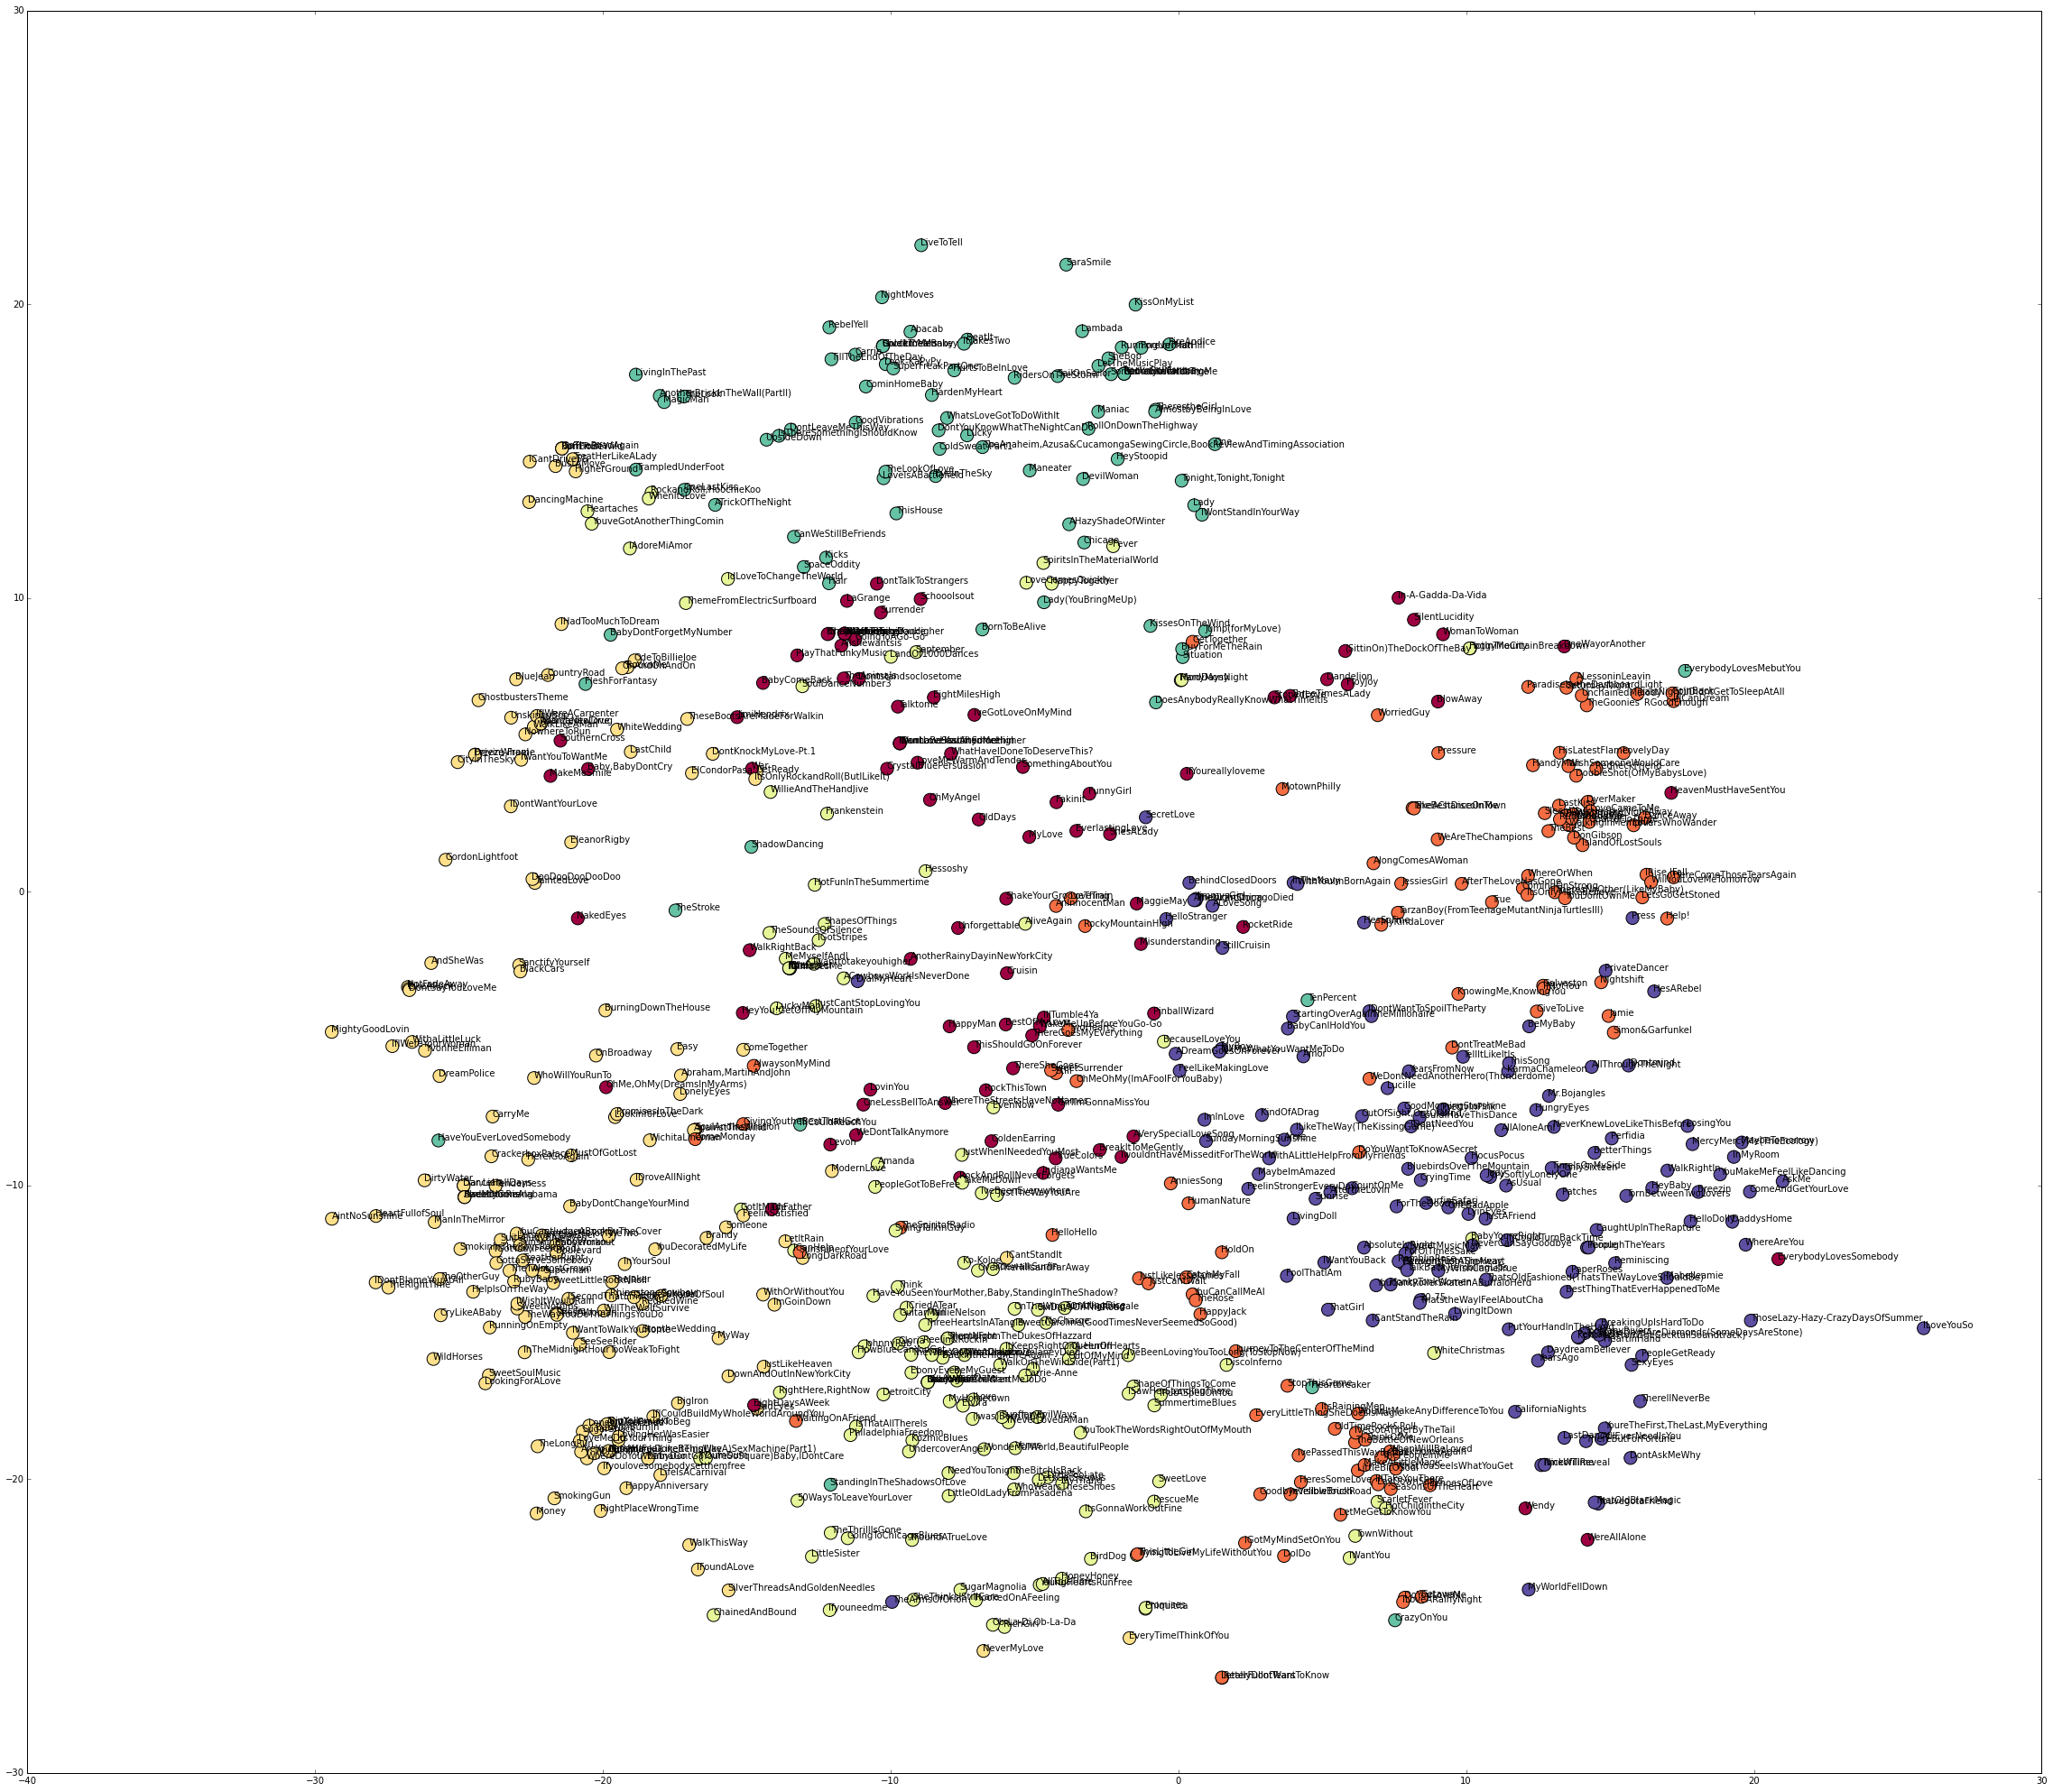

In [44]:
# Try t-sne
from sklearn import manifold

#fig, ax = plt.subplots()
plt.figure(figsize=(40,35))
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_mat)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = km.labels_, s = 200, cmap=plt.cm.Spectral)

ax = plt.gca()

for i, txt in enumerate(Y):
    ax.annotate(txt, (X_tsne[i, 0], X_tsne[i, 1]))

### Compute distances between every pair of songs and save into json files.
#### These files can be used as input file to graph.html to visualize a force directed graph using D3

In [46]:
# Add center clusters to X, Y so that we can visualize them on the graph
Y = Y + ['CLUSTER0', 'CLUSTER1','CLUSTER2','CLUSTER3','CLUSTER4','CLUSTER5']
X =  np.concatenate((X_mat,km.cluster_centers_), axis = 0)

# Define dictionary of song names and song indices
song_dict = dict()
for i in range(0, len(Y)):
    song_dict[Y[i]] = X[i]
    
song_index = dict()
for i in range(0, len(Y)):
    song_index[Y[i]] = i
    
song_index['CLUSTER0'] = i+1
song_index['CLUSTER1'] = i+2
song_index['CLUSTER2'] = i+3
song_index['CLUSTER3'] = i+4
song_index['CLUSTER4'] = i+5
song_index['CLUSTER5'] = i+6

In [47]:
# Compute distances between every two songs
import itertools
from scipy.spatial import distance

pairs_cosine = dict()
pairs_euclidean = dict()

counter = 0
for song_pair in itertools.combinations(Y, 2):
    pairs_cosine[song_pair] = distance.cosine(song_dict[song_pair[0]],song_dict[song_pair[1]])
    pairs_euclidean[song_pair] = distance.euclidean(song_dict[song_pair[0]],song_dict[song_pair[1]])
    counter += 1
print 'Number of pairs: ' + str(counter)

Number of pairs: 270480


In [48]:
#Normalize euclidean distances to 0-1 range
max_dist = max(pairs_euclidean.values())
min_dist = min(pairs_euclidean.values())

def min_max_scaler(x, min_, max_):
    return (x-min_)/(max_-min_)

In [49]:
# Filter out NaN distances and scale to range 0-1 (only needed with Euclidean distance)
import math
graph_cosine = pairs_cosine.items()
graph_cosine = [i for i in graph_cosine if math.isnan(i[1]) == False]
graph_euclidean = pairs_euclidean.items()
graph_euclidean = [(i[0], min_max_scaler(i[1], min_dist, max_dist)) for i in graph_euclidean if math.isnan(i[1]) == False]

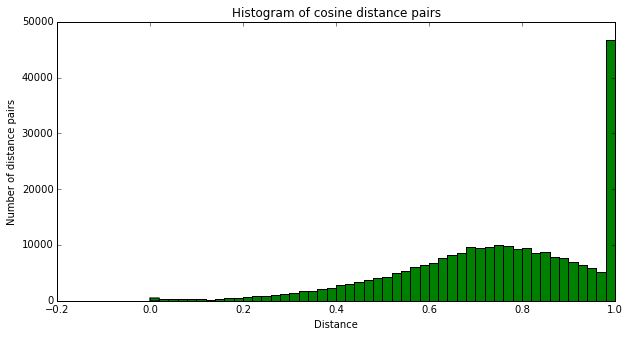

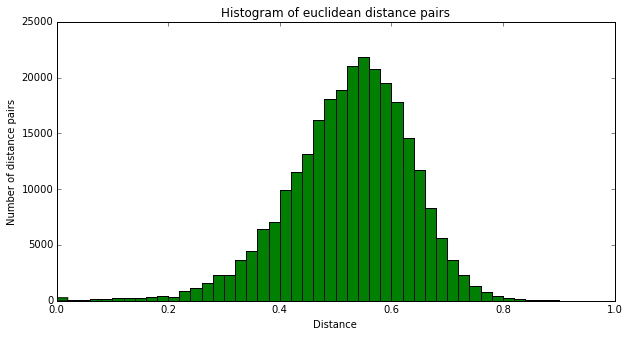

In [50]:
# Plot distribution of distances
plt.figure(figsize=(10,5))
plt.ylabel('Number of distance pairs')
plt.xlabel('Distance')
plt.title('Histogram of cosine distance pairs')
plt.hist([i[1] for i in graph_cosine], bins = 50, color = 'green')
plt.show()

plt.figure(figsize=(10,5))
plt.ylabel('Number of distance pairs')
plt.xlabel('Distance')
plt.title('Histogram of euclidean distance pairs')
plt.hist([i[1] for i in graph_euclidean], bins = 50, color = 'green')
plt.show()

In [51]:
# Manually create JSON file
json_nodes = '''"nodes": [''' + '\n'
for title, cluster in zip(Y, km.labels_):
    json_nodes += '''{"id": "''' + title + '''", "group": ''' + str(cluster) + '''},''' + '\n'
    
json_nodes = json_nodes[:-2] + '\n'+ ''']'''

In [52]:
# Links using cosine distance
json_links = '''"links": [''' + '\n'
for song_pair, dist in graph_cosine:
    if dist < 0.9:
        json_links += '\t' + '''{"source": ''' + str(song_index[song_pair[0]]) + ''', "target": ''' + str(song_index[song_pair[1]]) + ''', "value": ''' + str(dist) + '''},''' + '\n' 
json_links = json_links[:-2] + '\n'+ ''']'''

json_string = '''{''' + json_nodes + ''',''' + json_links + '''}'''

text_file = open("graph_cosine.json", "w")
text_file.write(json_string)
text_file.close()

In [53]:
# Links using euclidean distance
json_links = '''"links": [''' + '\n'
for song_pair, dist in graph_euclidean:
    if dist < 0.9:
        json_links += '\t' + '''{"source": ''' + str(song_index[song_pair[0]]) + ''', "target": ''' + str(song_index[song_pair[1]]) + ''', "value": ''' + str(dist) + '''},''' + '\n' 
json_links = json_links[:-2] + '\n'+ ''']'''

json_string = '''{''' + json_nodes + ''',''' + json_links + '''}'''

text_file = open("graph_euclidean.json", "w")
text_file.write(json_string)
text_file.close()

### Try hierarchical clustering

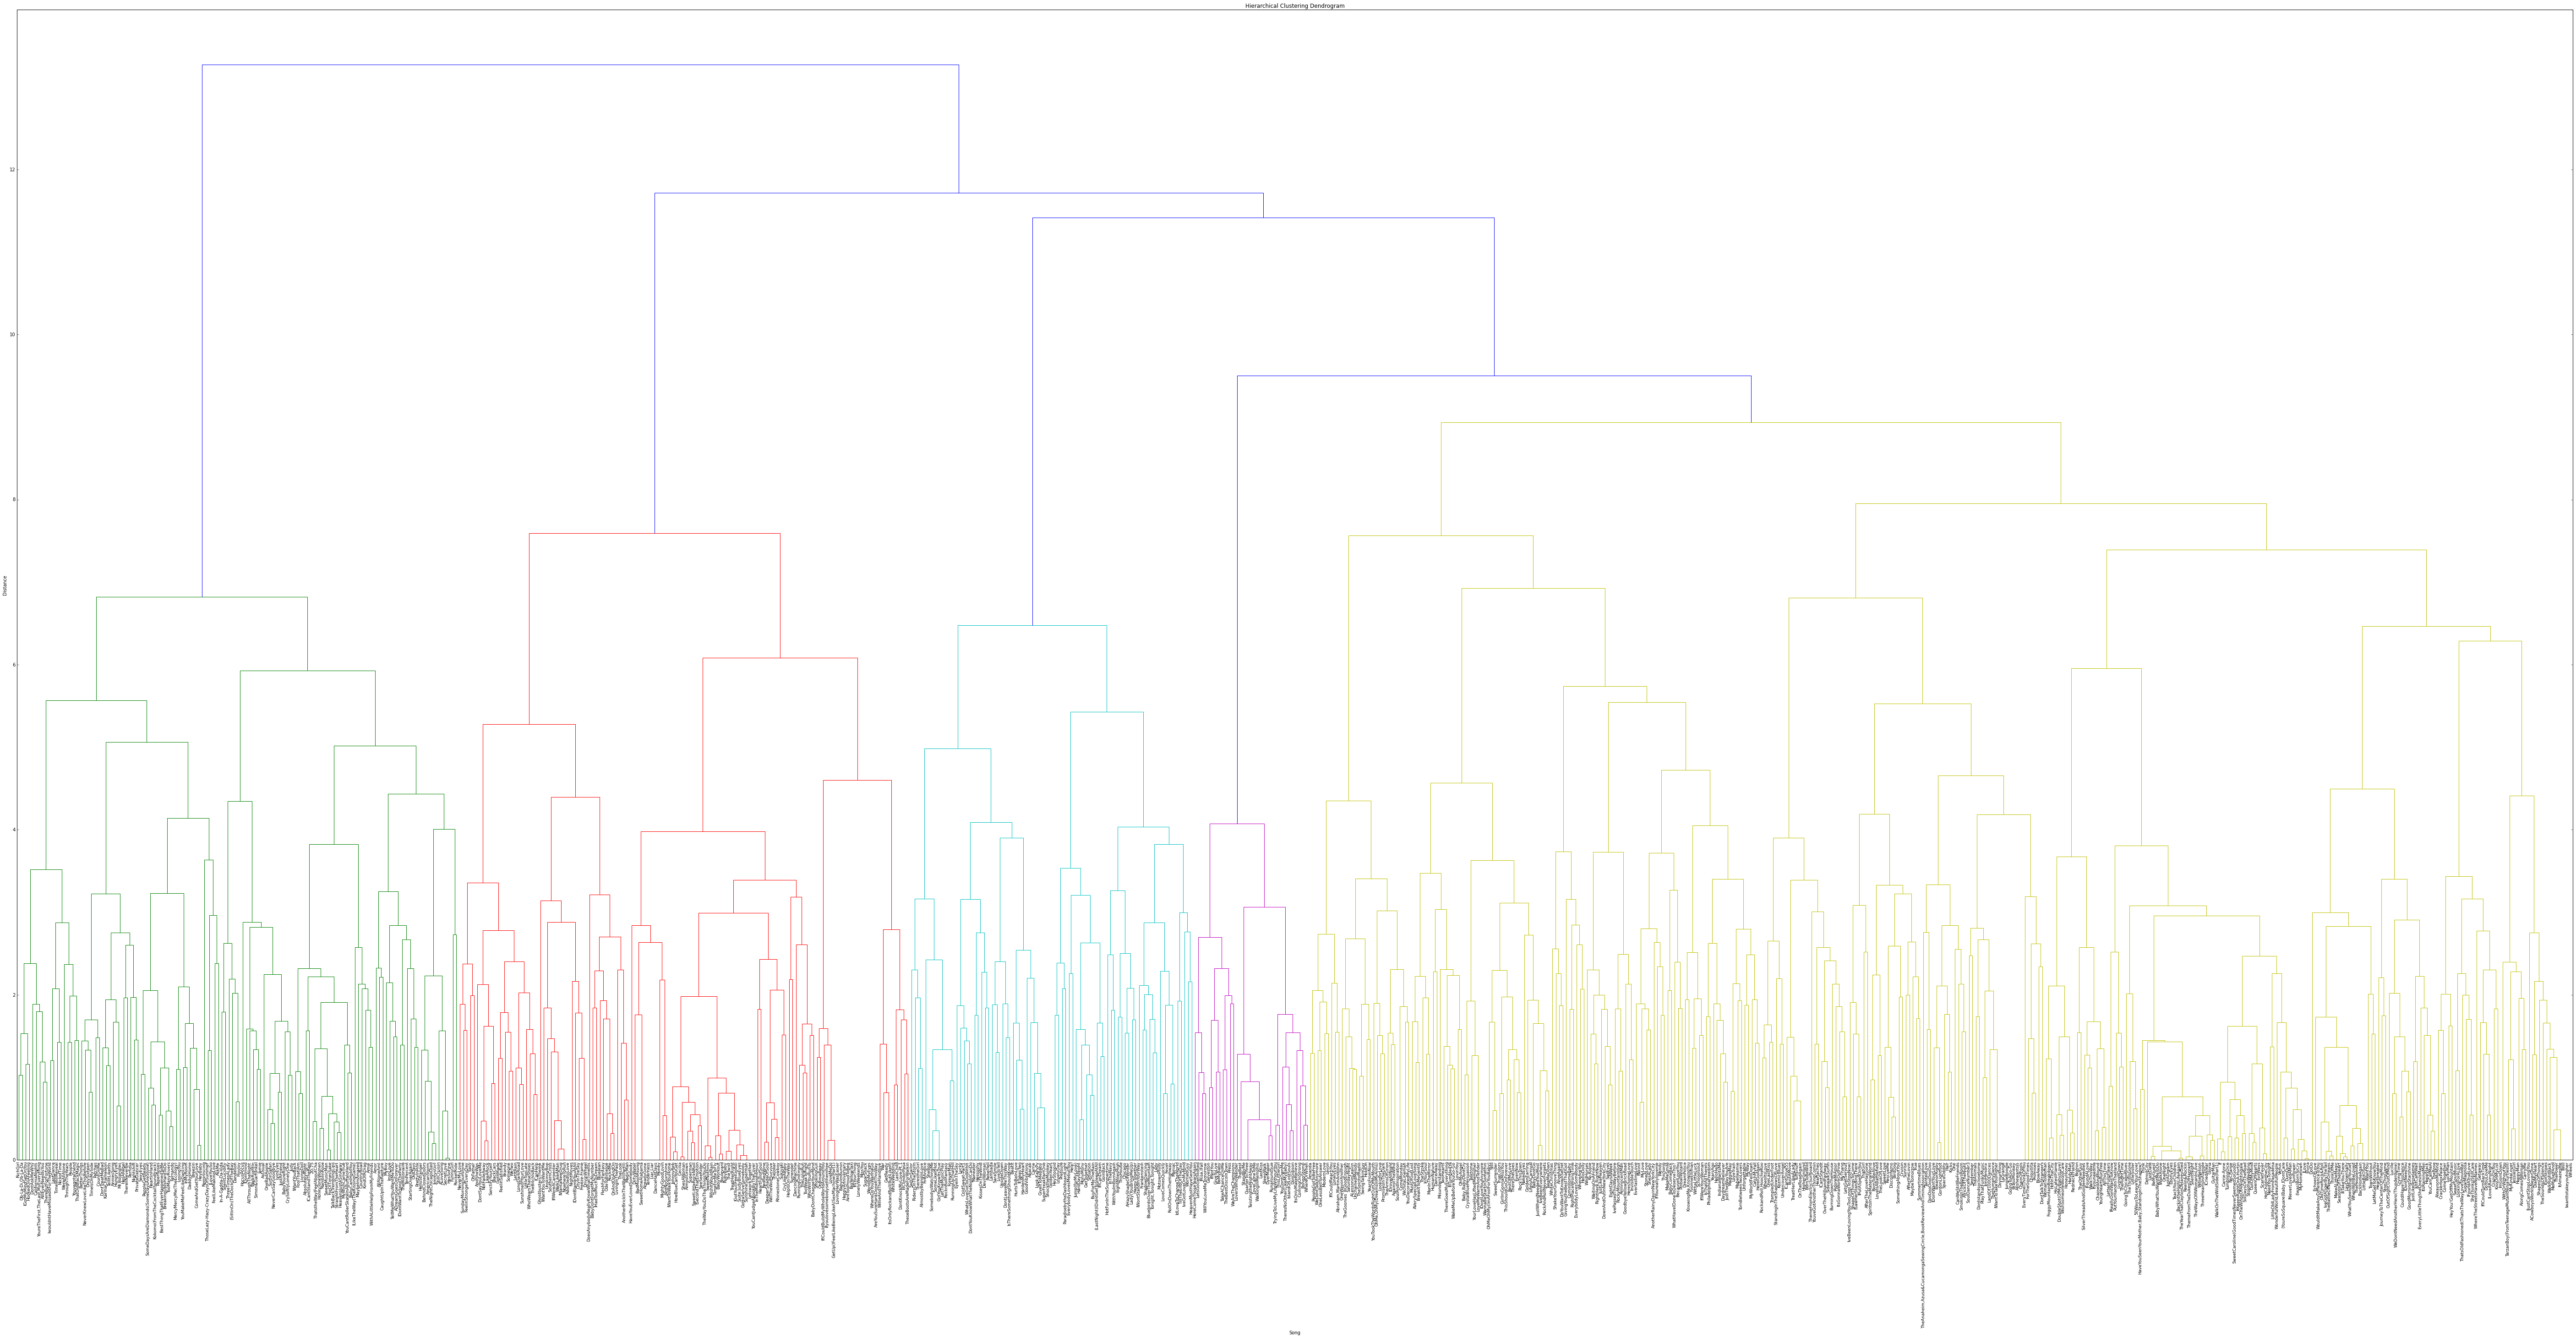

In [45]:
# Hierarchical clustering with Scipy -- This method is not using K-means results!!
from scipy.cluster.hierarchy import dendrogram, linkage

# generate the linkage matrix
Z = linkage(X_mat, 'ward')
# calculate full dendrogram
plt.figure(figsize=(100,45))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Song')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,leaf_font_size=9., labels = Y)
plt.show()